# corpus내 어휘 수 많아지면 속도 너무 오래 걸림 (밑에서 시간 비교)
1. Embedding 계층 도입
2. 네거티브 샘플 손실 함수 도입입


## 1. Embedding 계층
- 사실 look-up tabel 특정 행만 추출하는거라 matrix multiplication 필요없음
- 그래서 그냥 인덱스로 그 행만(word embedding) 뽑아낼거임
- 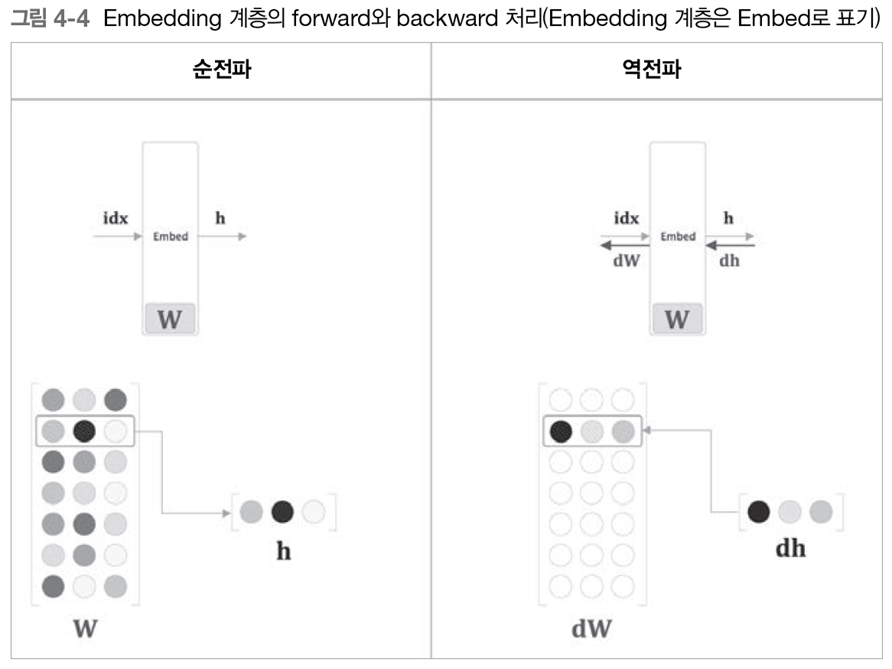

In [16]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params # unpacking a single element from a tuple or a list, W = self.params[0]
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        #dW[self.idx] = dout >> 이런식으로 가면 idx 중복 (0,2,0,4)일때 덮어쓰여져서 안된다
        
        # for i, word_id in enumerate(self.idx):
        #     dW[word_id] += dout[i]
        np.add.at(dW, self.idx, dout) # dout을 dW의 idx행에 더해준다     
        return None        

## 2.1 네거티브 샘플링 - 다중분류에서 이진분류로!
- 2번째 완열계에서의 행렬곱과 softmax 층 계산에서 병목 (계산량 투머치)
 
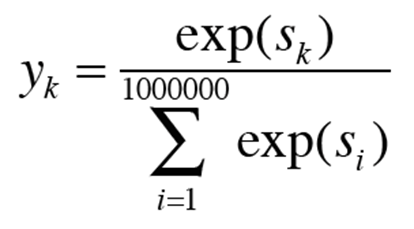</br>

- softmax with cross entropy loss는 multi-class classification이었음
- 이걸 binary classification으로 근사할 것임 (yes=1/no=0)
### - "sigmoid(0~1) /w cross entropy loss"
- 0~1 실수니까 확률로 해석 가능!
- contexts가 you와 goodbye일 때, target이 say입니까? -> 타겟에 해당하는 col만 추출해서 은닉층 뉴런과 내적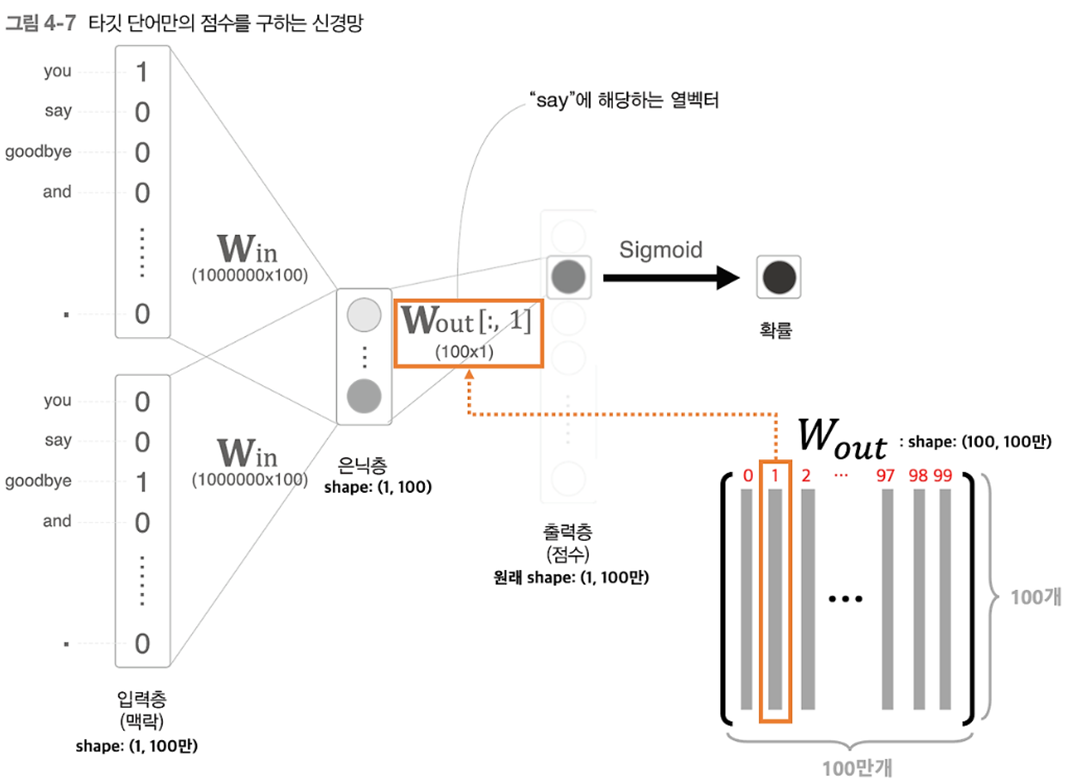


In [ ]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None # 역전파 때 쓰기 위해 순전파 결과 저장(h, target_W)

    def forward(self, h, idx):
        '''
        W        : (vocab, hidden) -> 원래는 h,v 
        idx      : (#mini_batch,) -> 정답 idx 각 각
        target_W : (#mini_batch, hidden)
        h        : (#mini_batch, hidden)
        
        target_W
        * h      : (#mini_batch, hidden) -> np * -> element-wise

        out      : (hidden,)
        '''
               
        target_W = self.embed.forward(idx) 
        out = np.sum(target_W * h, axis=1) # dot product
                                           # * 연산하면 shape 안맞춰줘도 돼서 편함
                                           # 어차피 (h,)*(h,)
        self.cache = (h, target_W)
        return out
                                           
    def backward(self, dout): # sigmoid with loss (batch,)
        # 그냥 흘려보내면 된다.
        h, target_W = self.cache        
        # dout = (batch,) -> 행렬 곱 수행 위해 reshape
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h # (batch,1) * (batch, hidden)
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh        

In [17]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None # 역전파 때 쓰기 위해 순전파 결과 저장 : h, target_W

    def forward(self, h, idx):
        target_W = self.embed.forward(idx) # look-up 뽑아내기
        out = np.sum(target_W * h, axis=1) # 뽑아낸거랑 hidden 이랑 곱함
                                           # 그리고나서 row끼리 더함 (행렬곱이 그런식으로 되잖아)
        self.cache = (h, target_W)
        return out

    def backward(self,dout): # dout는 sigmoid /w loss (batch,)
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1) # (batch, 1) 2d
        # dot product 의 역전파는 크로스해서 곱해주는 것!
        dtarget_W = dout * h # (batch,1) * (batch, hidden)
        self.embed.backward(d_target_W) # np.add.at(dW, self.idx, d_target_W) # d_target_W을 dW의 idx행에 더해준다     
        dh = dout * target_W

## 2.2 네거티브 샘플링 : 적은 수의 부정적 예를 샘플링해 사용
- 어휘 수 너무 많으면 감당불가여서 조금만 택
- 긍정적 예 말고 부정적 예도 학습해야지 된다
- 0 / 1


### 어떻게 샘플링할 것인가?
- 코퍼스 내의 빈도 기준!
- 어차피 train set에서도 적게 나온 애들은 실전 문제에서도 적게 나올 것임

In [18]:
words = ['i', 'love', 'you']
p = [0.1, 0.8, 0.1]
np.random.choice(words, p=p)

'love'

### 그런데 (아마 논문에서) 기존 확률분포에 0.75를 곱하라고 제안했음
### 이유는 출현 확률이 낮은 단어를 아예 버리지 않기 위해서임
### 그래서 그냥 0.75제곱을해서 normalization 까지
- 아래 코드에서 보면 정말로 0.1이 조금 더 높아진걸 확인할 수 있음
- 
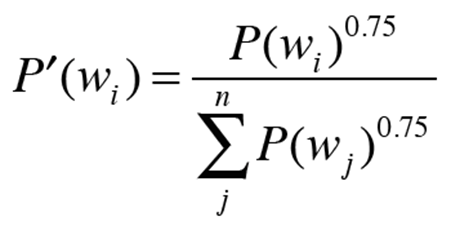

- 유니그램Unigram : 하나의 단어를 대상으로 확률분포- 
바이그램Bigram :연속된  두 단어로 구성된 대상에 대한 확률분


In [20]:
words = ['i', 'love', 'you']
p = [0.1, 0.8, 0.1]
new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)
print(new_p)

[0.14799843 0.70400314 0.14799843]


In [23]:
import sys
sys.path.append('..')
from common import layers
from negative_sampling_layer import UnigramSampler

class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)

        # layers : 긍정적 예를 다루는 계층 + sample_size만큼 부정적 예를 다루는 계층!!
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)] # 1개 더(긍정)
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        self.params, self.grads = [], []

        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32) # label 1
        loss = self.loss_layers[0].forward(score, correct_label)

        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i] # all batch
            score = self.embed_dot_layers[1 + i].forward(h, target) # [0]은 긍정적 예시 꺼
            loss = self.loss_layers[1 + i].forward(score, correct_label)
        return loss

    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout) # loss 미분
            dh += l1.backward(dscore) # embeddingdot은 dloss가 params
                                      # hidden layer neuron이 여러 embed_dot_layers에 복사됐었음. repeat node! 쪼개진거 하나로(그래프 생각해보기)

# CBOW

In [25]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import Embedding
from ch04.negative_sampling_layer import NegativeSamplingLoss

class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 1. 가중치 초기화 ~N(표준편차0.01)
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H) # 임베딩 벡터 row 방향 배치 (아까 만든 embedding 계층 통일해서 쓸라고)
        
        # 2. 계층 생성 : embedding(w_in) -> negativesamplingloss(embedding, w_out & loss)
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5) # corpus, unigramsampler에서 vocab 만듦

        # 3. 모든 가중치와 기울기를 배열에 모으기
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # 4. 인스턴스 변수에 단어 분산 표현 저장
        self.words_vecs = W_in

    def forward(self, contexts, target): # contexts 2d, target 1d
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:,i]) # 첫번째 타겟부터 순서대로~
        h *= 1 / len(self.in_layers) # 평균!!!
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers: # 윈도우 내 애들 embedding layer
            layer.backward(dout)
        return None

# 시간 비교

In [ ]:
import sys
sys.path.append('..')
import numpy as np
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from cbow import CBOW
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb
from common import config # GPU = False
##config.GPU = True
import time

# 1. 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 2. 데이터 읽기 & contexts,target 생성
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# 3. 모델, 옵티마이저 생성 -> trainer 객체 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 4. 학습 시작
start = time.time()
trainer.fit(contexts, target, max_epoch, batch_size)
end = time.time()
print(f'걸린 시간 : {(end - start)}')
trainer.plot()

# 5. 필요한 데이터 저장 (나중에 사용 가능케) : 워드벡터, 파라미터 {} -> 피클
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 1[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 3[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 4[s] | 손실 4.13
| 에폭 1 |  반복 81 / 9295 | 시간 5[s] | 손실 4.05
| 에폭 1 |  반복 101 / 9295 | 시간 7[s] | 손실 3.93
| 에폭 1 |  반복 121 / 9295 | 시간 8[s] | 손실 3.78
| 에폭 1 |  반복 141 / 9295 | 시간 9[s] | 손실 3.63
| 에폭 1 |  반복 161 / 9295 | 시간 10[s] | 손실 3.49
| 에폭 1 |  반복 181 / 9295 | 시간 12[s] | 손실 3.35
| 에폭 1 |  반복 201 / 9295 | 시간 13[s] | 손실 3.24
| 에폭 1 |  반복 221 / 9295 | 시간 14[s] | 손실 3.16
| 에폭 1 |  반복 241 / 9295 | 시간 15[s] | 손실 3.08
| 에폭 1 |  반복 261 / 9295 | 시간 16[s] | 손실 3.01
| 에폭 1 |  반복 281 / 9295 | 시간 18[s] | 손실 2.96
| 에폭 1 |  반복 301 / 9295 | 시간 19[s] | 손실 2.93
| 에폭 1 |  반복 321 / 9295 | 시간 21[s] | 손실 2.88
| 에폭 1 |  반복 341 / 9295 | 시간 22[s] | 손실 2.82
| 에폭 1 |  반복 361 / 9295 | 시간 24[s] | 손실 2.83
| 에폭 1 |  반복 381 / 9295 | 시간 25[s] | 손실 2.80
| 에폭 1 |  반복 401 / 9295 | 시간 27[s] | 손실 2.77
| 에폭 1 |  반복 421 / 9295 | 시간 28[s] | 손실 2.72
| 에폭 1 |  반복 441 / 9295 

In [ ]:
from common.util import analogy, normalize

analogy('king', 'man', 'queen', word_to_id, id_to_word, word_vecs) # 데이터셋 안에 있는 단어들
analogy('take', 'took', 'go', word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child', word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad', word_to_id, id_to_word, word_vecs)

In [12]:
import os
import sys
# Adding the path to 'DeepLearningFromScratch/2/ch03' to sys.path
# Adding the base directory to sys.path
base_dir = os.path.join(os.getcwd(), 'DeepLearningFromScratch', '2')
sys.path.append(base_dir)
from ch03.simple_cbow import SimpleCBOW

In [ ]:
import sys
sys.path.append('..')
import numpy as np
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from cbow import CBOW
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb
from common import config # GPU = False
##config.GPU = True
import time

# 1. 하이퍼파라미터 설정
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# 2. 데이터 읽기 & contexts,target 생성
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

# 3. 모델, 옵티마이저 생성 -> trainer 객체 생성
#model = CBOW(vocab_size, hidden_size, window_size, corpus)
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 4. 학습 시작
start = time.time()
trainer.fit(contexts, target, max_epoch, batch_size)
end = time.time()
print(f'걸린 시간 : {(end - start)}')
trainer.plot()

# 5. 필요한 데이터 저장 (나중에 사용 가능케) : 워드벡터, 파라미터 {} -> 피클
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 손실 3.89
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 손실 3.89
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 손실 3.89
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 손실 3.89
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 손실 3.89
| 에폭 6 |  반복 1 / 19 | 시간 0[s] | 손실 3.89
| 에폭 7 |  반복 1 / 19 | 시간 0[s] | 손실 3.89
| 에폭 8 |  반복 1 / 19 | 시간 0[s] | 손실 3.89
| 에폭 9 |  반복 1 / 19 | 시간 0[s] | 손실 3.88
| 에폭 10 |  반복 1 / 19 | 시간 0[s] | 손실 3.88
| 에폭 11 |  반복 1 / 19 | 시간 0[s] | 손실 3.88
| 에폭 12 |  반복 1 / 19 | 시간 0[s] | 손실 3.87
| 에폭 13 |  반복 1 / 19 | 시간 0[s] | 손실 3.86
| 에폭 14 |  반복 1 / 19 | 시간 0[s] | 손실 3.86
| 에폭 15 |  반복 1 / 19 | 시간 0[s] | 손실 3.85
| 에폭 16 |  반복 1 / 19 | 시간 0[s] | 손실 3.84
| 에폭 17 |  반복 1 / 19 | 시간 0[s] | 손실 3.84
| 에폭 18 |  반복 1 / 19 | 시간 0[s] | 손실 3.83
| 에폭 19 |  반복 1 / 19 | 시간 0[s] | 손실 3.82
| 에폭 20 |  반복 1 / 19 | 시간 0[s] | 손실 3.81
| 에폭 21 |  반복 1 / 19 | 시간 0[s] | 손실 3.80
| 에폭 22 |  반복 1 / 19 | 시간 0[s] | 손실 3.79
| 에폭 23 |  반복 1 / 19 | 시간 0[s] | 손실 3.77
| 에폭 24 |  반복 1 / 19 | 시간 0[s] | 손실 3.76
| 에폭 25 |  반복 1 / 19 | 시간

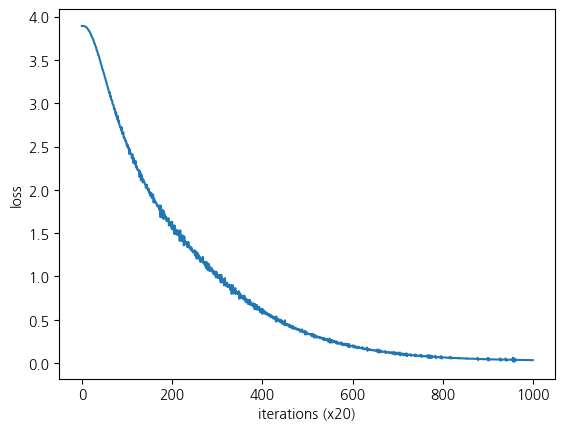

In [31]:
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot
import time
import matplotlib.pyplot as plt

# 1. hyperparameter
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

# 2. data preprcessing
text = "In the quiet town of Willowbrook, nestled between rolling hills and dense forests, an ancient secret lay hidden beneath the cobblestone streets, a secret that, if uncovered, promised to unravel the very fabric of the town's idyllic existence, revealing a past interwoven with mystery, intrigue, and a legacy of long-forgotten powers that many believed to be mere legends."
corpus, word_to_id, id_to_word = preprocess(text)

# 3. ont hot encoding
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

# 4. model, optmizing 설정
model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()

# 5. training
trainer = Trainer(model, optimizer) # 초기화
start = time.time()
trainer.fit(contexts, target, max_epoch, batch_size) # 학습
end = time.time()
print(f'train 시간 : {end - start}')
plt.rcParams['font.family'] = 'NanumGothic'
trainer.plot()